In [1]:
%pylab inline
import numpy as np
import scipy.stats as spstats
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [5]:
df_runs = pd.DataFrame.from_csv("output/2017-07-24-sample_3.csv")
df_values = pd.DataFrame.from_csv("output/2017-07-24-sample_3-values.csv")
rs = sorted(set(df_runs["rewire"]))
strategies = sorted(set(df_values["strategy"]))
trials = sorted(set(df_values["trial"]))
steps = sorted(set(df_values["step"]))

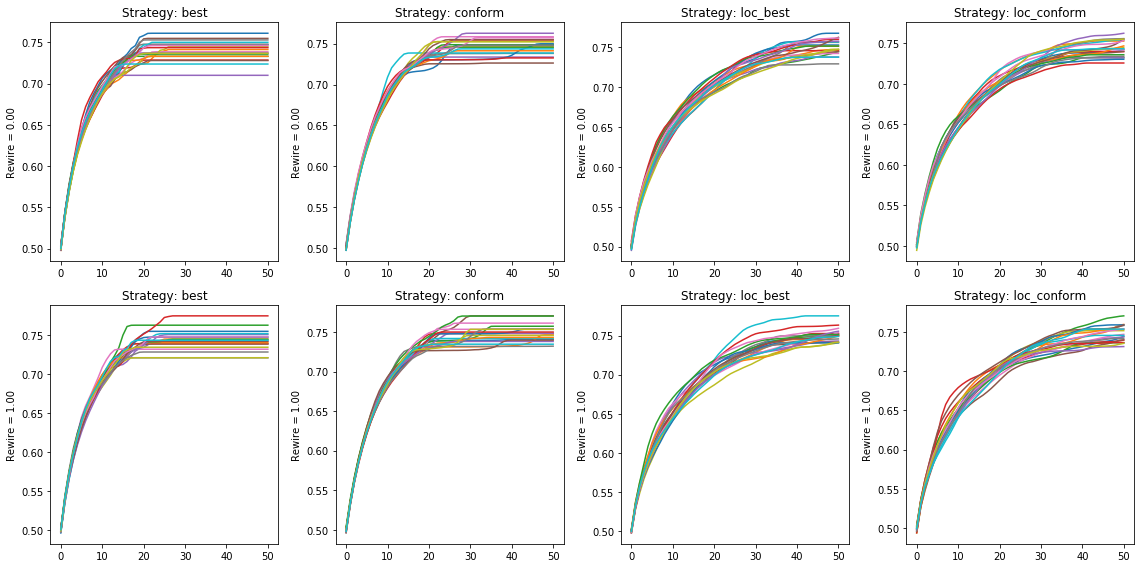

In [3]:
plt.figure(figsize=(16,4*len(rs)))
for i, r in enumerate(rs):
    df_rewire = df_values[df_values["rewire"] == r]
    for j, strategy in enumerate(strategies):
        df_strategy = df_rewire[df_rewire["strategy"] == strategy]
        plt.subplot(len(rs),len(strategies),1+j+i*len(strategies))
        plt.title("Strategy: %s" % strategy)
        plt.ylabel("Rewire = %0.2f" % r)
        for trial_n in trials:
            df_trial = df_strategy[df_strategy["trial"] == trial_n]
            plot(df_trial["step"], df_trial["value"])
plt.tight_layout()

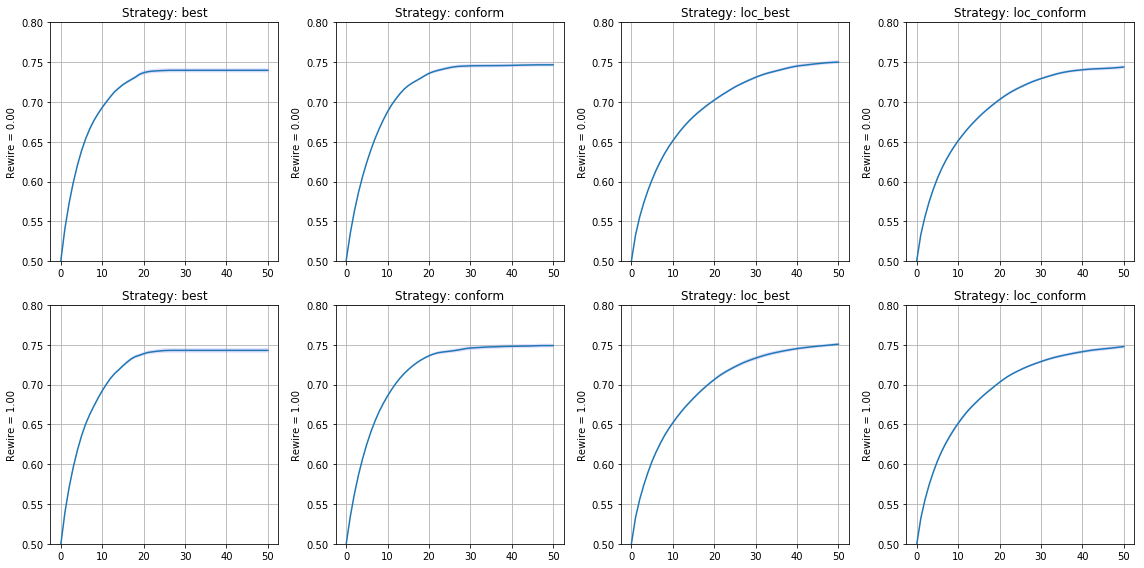

In [14]:
df_grouped = df_values.groupby(["strategy", "rewire", "step"])
plt.figure(figsize=(16,4*len(rs)))
for i, r in enumerate(rs):
    df_rewire = df_values[df_values["rewire"] == r]
    for j, strategy in enumerate(strategies):
        df_strategy = df_rewire[df_rewire["strategy"] == strategy]
        plt.subplot(len(rs),len(strategies),1+j+i*len(strategies))
        plt.title("Strategy: %s" % strategy)
        plt.ylabel("Rewire = %0.2f" % r)
        step_mean = []
        step_se = []
        for step in sorted(set(df_strategy["step"])):
            df = df_strategy[df_strategy["step"] == step]
            step_mean.append(df["value"].mean())
            s = df["value"].std(ddof=1)
            step_se.append(s / sqrt(len(df["value"])))
        mean = np.array(step_mean)
        se = np.array(step_se)
        plt.fill_between(range(len(step_mean)), mean - se, mean + se, facecolor="#dfdfff")
        plt.plot(step_mean)
        plt.grid()
        plt.ylim([0.5, 0.8])
plt.tight_layout()

In [41]:
for i, r in enumerate(rs):
    df_rewire = df_values[df_values["rewire"] == r]
    print "Rewire: %f" % r
    for j, strategy in enumerate(strategies):
        df_strategy = df_rewire[df_rewire["strategy"] == strategy]
        df = df_strategy[df_strategy["step"] == steps[-1]]
        m = df["value"].mean()
        sd = df["value"].std()
        se = sd / sqrt(len(df["value"]))
        print "\t%s:\t%f\t%f" % (strategy, m, se)

Rewire: 0.000000
	best:	0.739808	0.002660
	conform:	0.746705	0.002110
	loc_best:	0.750162	0.002145
	loc_conform:	0.744026	0.002308
Rewire: 1.000000
	best:	0.743004	0.002881
	conform:	0.749012	0.002340
	loc_best:	0.750743	0.001867
	loc_conform:	0.747730	0.002298


In [29]:
def values_to_efficiency(values):
    start = values[0]
    halfmax = (max(values) - start) / 2.0 + start
    return 1.0 / float(len([v for v in values if v <= halfmax]))

In [35]:
for i, r in enumerate(rs):
    df_rewire = df_values[df_values["rewire"] == r]
    print "Rewire: %f" % r
    for j, strategy in enumerate(strategies):
        df_strategy = df_rewire[df_rewire["strategy"] == strategy]
        strategy_trials = sorted(set(df_strategy["trial"]))
        efficiencies = np.zeros(len(strategy_trials))
        for i, trial in enumerate(strategy_trials):
            df = df_strategy[df_strategy["trial"] == trial]
            efficiencies[i] = values_to_efficiency(list(df["value"]))
        m = efficiencies.mean()
        sd = efficiencies.std()
        se = sd / sqrt(len(efficiencies))
        print "\t%s:\t%f\t%f" % (strategy, m, se)

Rewire: 0.000000
	best:	0.222500	0.005562
	conform:	0.181667	0.003708
	loc_best:	0.135119	0.002529
	loc_conform:	0.141270	0.003136
Rewire: 1.000000
	best:	0.211667	0.006021
	conform:	0.185000	0.003708
	loc_best:	0.135913	0.003512
	loc_conform:	0.137381	0.004985
